In [6]:
import numpy as np
from matplotlib import pyplot as plt
from mip import *
import math

# Nomenclature
- $N$: Number of charging poles at the parking station.
- $𝐻$: Total available time period for charging during a day.
- $𝑇_s$: Sampling interval.
- $𝐽$: Number of intervals in the time period, $J = H/T_s$.
- $𝑡^{arr}_𝑛$: Real arrival time of the EV connected to the 𝑛-th charging pole.
- $𝜅^{arr}_𝑛$: Arrival time step, $𝜅^{arr}_n = ⌈𝑡^{arr}_n / T_s⌉$.
- $𝑡^{dep}_𝑛$: Estimated departure time provided by the EV driver to the 𝑛-th charging pole.
- $𝜅^{dep}_𝑛$: Departure time step, $𝜅^{dep}_n = ⌊𝑡^{dep}_n / T_s⌋$.
- $𝛿_𝑛^𝑗$: Binary parameter indicating the connect status of the 𝑛-th charging pole at the 𝑗-th time step.
  - $𝛿_𝑛^𝑗$ = 1: 𝑛-th charging pole is occupied.
  - $𝛿_𝑛^𝑗$ = 0: 𝑛-th charging pole is not occupied.
- $𝑃^{c,max}_𝑛$: Maximum charging power provided to the EV connected to the 𝑛-th charging pole.
- $𝑃^{d,max}_𝑛$: Maximum discharging power drawn from the EV connected to the 𝑛-th charging pole.
- $s^{c,𝑗}_𝑛$: Charging rate of the 𝑛-th charging pole at the 𝑗-th time step, $s^{c,𝑗}_𝑛 ∈ [0, 1]$.
- $s^{d,𝑗}_𝑛$: Discharging rate of the 𝑛-th charging pole at the 𝑗-th time step, $s^{d,𝑗}_𝑛 ∈ [0, 1]$.
- $𝐷_𝑛^𝑗$: Remaining charging time steps of the EV connected to the 𝑛-th charging pole at the 𝑗-th time step, $𝐷_𝑛^𝑗 = 𝜅^{dep}_𝑛 − 𝑗$.
- $𝛾^{max}_𝑛$: Upper limit of State of Charge (SOC) of the EV connected to the 𝑛-th charging pole.
- $𝛾_𝑛^𝑗$: Current SOC level of the EV connected to the 𝑛-th charging pole.
- ${\gamma}^{dep}_n$: Final required SOC of the EV connected to the 𝑛-th charging pole.
- $𝛾^{int}_𝑛$: Initial State of Charge (SOC) of the EV connected to the 𝑛-th charging pole upon its arrival time step, $\kappa^{arr}_𝑛$.
- $𝐸^{cap}_𝑛$: Battery capacity of the EV connected to the 𝑛-th charging pole.
- $w^{c,𝑗}_𝑛$: Weighting of charging priority for the 𝑛-th connected EV at the 𝑗-th time step.
- $\alpha_{\max}$: Maximum value of day-ahead electricity prices.
- $\alpha_{\min}$: Minimum value of day-ahead electricity prices.
- $\alpha_𝑗$: Electricity price at the 𝑗-th time step.
- $\rho^{c,𝑗}_𝑛$: Preference level of the 𝑛-th charging pole to charge the connected EV at the 𝑗-th time step given the electricity price $a_𝑗$.
- $\rho^{d,𝑗}_𝑛$: Preference level of the 𝑛-th charging pole to discharge the connected EV at the 𝑗-th time step given the electricity price $a_𝑗$.
- $P_{grid}^{b,𝑗}$: Amount of electricity purchased from the power grid at the 𝑗-th time step.
- $P_{grid}^{s,𝑗}$: Amount of electricity sold to the power grid at the 𝑗-th time step.
- $P_{grid}^{max,𝑗}$: Capacity limit for the power exchanged with the grid at the 𝑗-th time step.
- $u_{grid}^{𝑗}$: Binary auxiliary variable indicating whether electricity is drawn from or discharged back to the grid at the 𝑗-th time step.
  - $u_{grid}^{𝑗} = 1$: Power is drawn from the grid.
  - $u_{grid}^{𝑗} = 0$: Otherwise.




In [7]:
# Test data
N = 100  # Number of charging poles
H = 24*4  # Total available time period for charging during a day (e.g., 24 hours)
T_s = 1  # Sampling interval (e.g., 1 hour)
J = int(H // T_s)  # Number of time steps

P_c_max = [20] * N  # Maximum charging power for each EV
P_d_max = [20] * N  # Maximum discharging power for each EV
P_max_grid = [200] * J  # Maximum power capacity limit of the grid at each time step

t_arr = [0] * N  # Arrival time for each EV
t_dep = [0] * N  # Departure time for each EV


gamma_max = [1.0] * N  # Upper limit of SOC for each EV
gamma_min = [0.2] * N  # Lower limit of SOC for each EV
gamma_int = [0.5] * N  # Initial SOC for each EV upon arrival
gamma_dep = [0.8] * N  # Final SOC for each EV upon departure
E_cap = [50] * N  # Battery capacity for each EV

# charging efficiencies
eta_c = 1
eta_d = 1

alpha_max = 1.4  # Maximum electricity price
alpha_min = 1.1  # Minimum electricity price
alpha = np.sin(np.linspace(0, 6 * np.pi, J)) * (alpha_max - alpha_min) / 2 + (alpha_max + alpha_min) / 2 + np.random.normal(scale=0.07, size=J) # Electricity price at each time step




In [8]:
# for n in range(N):
#     t_arr[n] = np.random.randint(0, H - 10)
#     t_dep[n] = np.random.randint(t_arr[n] + 10, H+1)

t_arr = [32, 5, 36, 72, 75, 19, 66, 22, 71, 7, 18, 75, 22, 10, 8, 41, 44, 84, 33, 53, 14, 53, 9, 51, 75, 78, 72, 68, 16, 8, 31, 32, 74, 54, 76, 78, 73, 29, 30, 50, 49, 37, 20, 22, 69, 30, 43, 85, 71, 26, 8, 49, 42, 34, 77, 22, 16, 84, 4, 78, 77, 41, 64, 56, 48, 39, 73, 77, 32, 21, 25, 42, 32, 44, 81, 60, 21, 67, 42, 32, 79, 41, 3, 12, 27, 58, 1, 55, 35, 0, 34, 64, 2, 75, 85, 31, 63, 57, 11, 35, 52, 55, 22, 16, 68, 46, 2, 71, 70, 1, 77, 54, 28, 64, 45, 39, 58, 84, 62, 37, 30, 79, 11, 21, 8, 43, 32, 74, 10, 83, 21, 58, 63, 12, 42, 17, 60, 55, 55, 78, 36, 4, 14, 40, 39, 47, 56, 28, 44, 48, 7, 72, 60, 58, 54, 44, 82, 77, 30, 36, 35, 52, 53, 29, 83, 19, 45, 71, 68, 76, 26, 56, 17, 79, 71, 10, 28, 19, 19, 30, 48, 41, 58, 58, 69, 21, 30, 10, 76, 0, 23, 61, 19, 22, 51, 39, 17, 9, 52, 80]
t_dep = [86, 76, 67, 88, 96, 37, 91, 90, 96, 60, 89, 90, 56, 79, 57, 61, 73, 96, 61, 93, 48, 64, 94, 92, 85, 95, 83, 86, 94, 38, 70, 55, 89, 72, 96, 92, 96, 40, 89, 96, 72, 92, 30, 41, 79, 70, 95, 96, 95, 94, 21, 80, 71, 62, 90, 61, 84, 94, 93, 94, 89, 91, 77, 67, 65, 72, 83, 95, 69, 82, 65, 52, 58, 70, 92, 84, 47, 88, 79, 56, 91, 74, 72, 34, 58, 79, 39, 82, 56, 22, 92, 84, 49, 85, 95, 64, 84, 80, 76, 79, 76, 79, 41, 47, 95, 94, 24, 86, 87, 92, 91, 84, 73, 79, 58, 76, 93, 96, 77, 87, 80, 91, 39, 89, 72, 54, 94, 94, 88, 93, 38, 93, 93, 50, 92, 45, 82, 70, 84, 89, 92, 87, 26, 81, 53, 57, 85, 54, 72, 75, 68, 87, 78, 84, 95, 75, 96, 93, 71, 70, 75, 85, 64, 63, 94, 32, 58, 90, 93, 86, 76, 92, 39, 92, 84, 23, 81, 44, 31, 96, 69, 57, 68, 91, 81, 55, 95, 68, 87, 30, 49, 95, 80, 83, 85, 67, 43, 55, 86, 92]

# Model
kappa_arr = [math.ceil(t/T_s) for t in t_arr]
kappa_dep = [math.floor(t/T_s) for t in t_dep]

model = Model(sense=MINIMIZE)

# Variables
s_c = [[model.add_var(var_type=CONTINUOUS, lb=0, ub=1) for j in range(J)] for n in range(N)]
s_d = [[model.add_var(var_type=CONTINUOUS, lb=0, ub=1) for j in range(J)] for n in range(N)]
u_grid = [model.add_var(var_type=BINARY) for j in range(J)]
P_b_grid = [model.add_var(lb=0) for j in range(J)]
P_s_grid = [model.add_var(lb=0) for j in range(J)]
u = [[model.add_var(var_type=BINARY) for j in range(J)] for n in range(N)]


# Parameters
delta = [[0] * J for n in range(N)]

w_c = [[0] * J for n in range(N)]
w_d = [[0] * J for n in range(N)]

gamma_current = [[0] * J for n in range(N)]  # Current SOC level for each EV

rho_c = [[0] * J for n in range(N)]
rho_d = [[0] * J for n in range(N)]
rho = [0] * J


for n in range(N):
  for j in range(J):
        if j >= kappa_arr[n] and j < kappa_dep[n]:
            delta[n][j] = 1
        else:
            delta[n][j] = 0

        if j == kappa_arr[n]:
            gamma_current[n][j] = gamma_int[n]

        
        if delta[n][j] == 1:
            D_j_n = kappa_dep[n] - j

            w_c[n][j] = (E_cap[n] * (gamma_max[n] - gamma_current[n][j])) / (P_c_max[n] * D_j_n)
            w_d[n][j] = (P_d_max[n] * D_j_n) / (E_cap[n] * (gamma_max[n] - gamma_current[n][j]))

            rho_c[n][j] = (alpha_max - alpha[j]) / (alpha_max - alpha_min)
            rho_d[n][j] = (alpha[j] - alpha_min) / (alpha_max - alpha_min)
        else:
            w_c[n][j] = 0
            w_d[n][j] = 0

            rho_c[n][j] = 0
            rho_d[n][j] = 0

for j in range(J):
    rho[j] = (alpha[j] - alpha_min) / (alpha_max - alpha_min)


# Constraints
for n in range(N):
    for j in range(J):
        model += s_c[n][j] <= delta[n][j]
        model += s_d[n][j] <= delta[n][j]

        charge_component = (eta_c*P_c_max[n]*s_c[n][j]*T_s/E_cap[n])
        discharge_component = (P_d_max[n]*s_d[n][j]*T_s/(eta_d*E_cap[n]))

        if j >= kappa_arr[n] and j <= kappa_dep[n]:
            model += s_c[n][j]*P_c_max[n] <= u[n][j]*P_c_max[n]
            model += s_d[n][j]*P_d_max[n] <= (1 - u[n][j])*P_d_max[n]            

            gamma_current[n][j] = gamma_current[n][j-1] + charge_component - discharge_component
            model += gamma_current[n][j] <= gamma_max[n]
            model += gamma_current[n][j] >= gamma_min[n]

for n in range(N):
    model += gamma_current[n][j] + xsum((eta_c*P_c_max[n]*s_c[n][j]*T_s/E_cap[n]) - (P_d_max[n]*s_d[n][j]*T_s/(eta_d*E_cap[n])) for j in range(J)) >= gamma_dep[n]

for j in range(J):
    model += P_b_grid[j] == xsum(s_c[n][j]*P_c_max[n] for n in range(N))
    model += P_s_grid[j] == xsum(s_d[n][j]*P_d_max[n] for n in range(N))
    
    model += P_b_grid[j] <= u_grid[j] * P_max_grid[j]
    model += P_s_grid[j] <= (1 - u_grid[j]) * P_max_grid[j]

# Objective function
# minimize peak load
model.objective = xsum(
    xsum(
        s_c[n][j] * P_c_max[n]*w_c[n][j]*rho_c[n][j] + s_d[n][j] * P_d_max[n]*w_d[n][j]*rho_d[n][j] for n in range(N))
        + rho[j]*(P_s_grid[j] - P_b_grid[j]) for j in range(J)
    )
model.sense = MAXIMIZE

# model.objective = xsum(s_c[n][j] * P_c_max[n] for n in range(N) for j in range(J))

# Optimize the model
model.optimize()


<OptimizationStatus.OPTIMAL: 0>

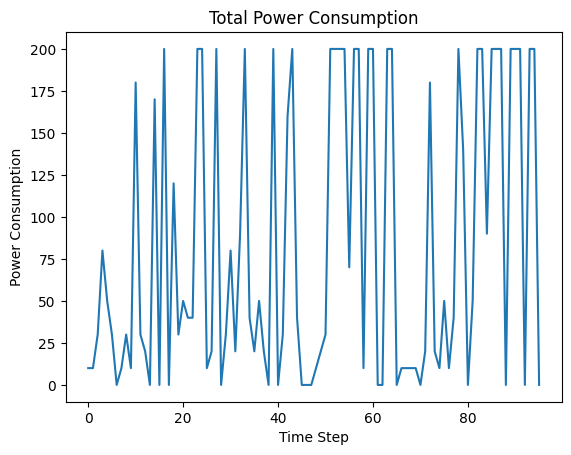

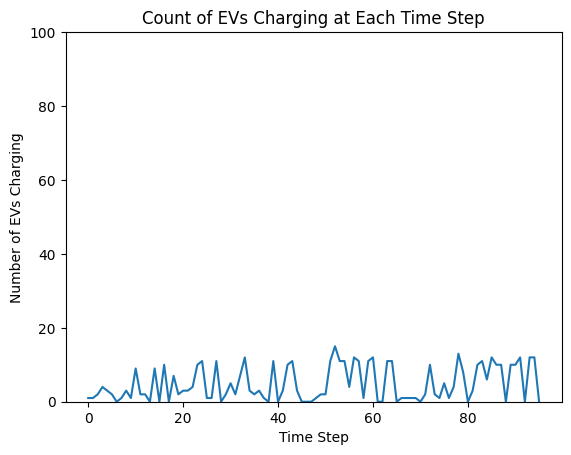

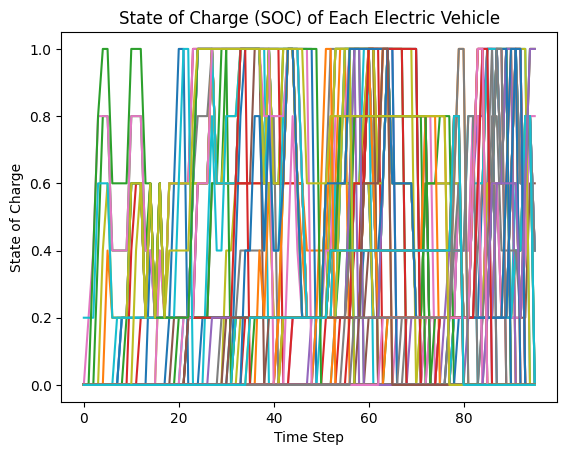

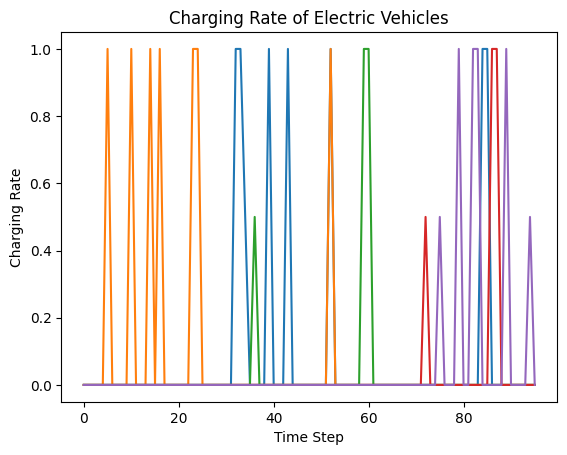

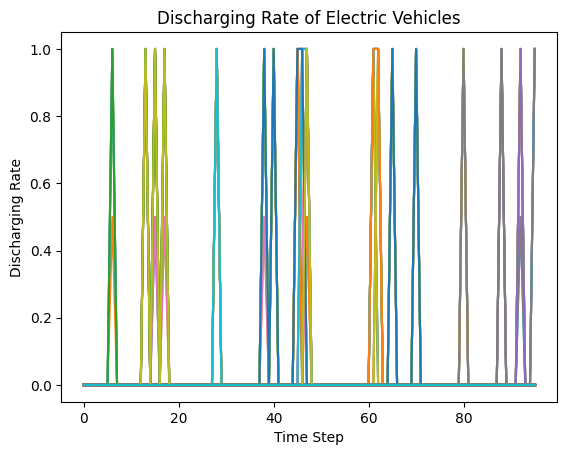

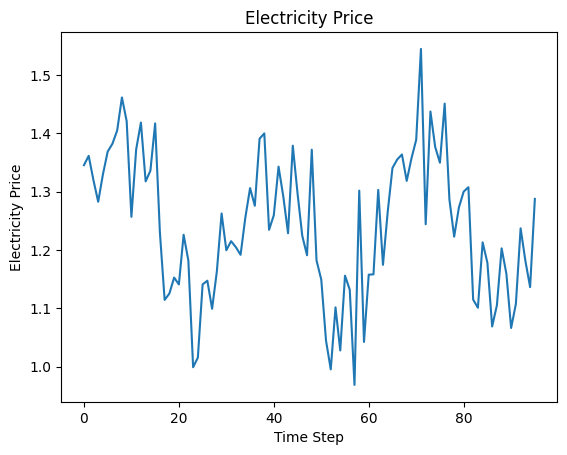

In [10]:
import matplotlib.pyplot as plt

# plot total power consumption
plt.plot(P_b_grid)
plt.title('Total Power Consumption')
plt.xlabel('Time Step')
plt.ylabel('Power Consumption')
plt.show()

# plot count of EVs charging at each time step
count = [0] * J
for j in range(J):
    for n in range(N):
        if s_c[n][j].x > 0:
            count[j] += 1

plt.plot(count)
plt.title('Count of EVs Charging at Each Time Step')
plt.xlabel('Time Step')
plt.ylabel('Number of EVs Charging')
plt.show()

# plot SOC of each EV
for n in range(N):
    plt.plot(gamma_current[n])
plt.title('State of Charge (SOC) of Each Electric Vehicle')
plt.xlabel('Time Step')
plt.ylabel('State of Charge')
plt.show()

# plot charging rate
for n in range(5):
    rate = [0] * J
    for j in range(J):
        rate[j] = s_c[n][j].x
    plt.plot(rate)
plt.title('Charging Rate of Electric Vehicles')
plt.xlabel('Time Step')
plt.ylabel('Charging Rate')
plt.show()

# plot discharging rate
for n in range(N):
    rate = [0] * J
    for j in range(J):
        rate[j] = s_d[n][j].x
    plt.plot(rate)
plt.title('Discharging Rate of Electric Vehicles')
plt.xlabel('Time Step')
plt.ylabel('Discharging Rate')
plt.show()

# plot electricity price
plt.plot(alpha)
plt.title('Electricity Price')
plt.xlabel('Time Step')
plt.ylabel('Electricity Price')
plt.show()
